In [1]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

C:\Users\Dell\anaconda3\envs\grad\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
C:\Users\Dell\anaconda3\envs\grad\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


TensorFlow Version: 2.10.0
Model Maker Version: 0.3.4


In [2]:
# @title [Run this] Util functions and data structures.

data_dir = './dataset/small_birds_dataset'

bird_code_to_name = {
  'wbwwre1': 'White-breasted Wood-Wren',
  'houspa': 'House Sparrow',
  'redcro': 'Red Crossbill',  
  'chcant2': 'Chestnut-crowned Antpitta',
  'azaspi1': "Azara's Spinetail",   
}

birds_images = {
  'wbwwre1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg/640px-Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg', #   Alejandro Bayer Tamayo from Armenia, Colombia 
  'houspa': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/House_Sparrow%2C_England_-_May_09.jpg/571px-House_Sparrow%2C_England_-_May_09.jpg', #    Diliff
  'redcro': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Red_Crossbills_%28Male%29.jpg/640px-Red_Crossbills_%28Male%29.jpg', #  Elaine R. Wilson, www.naturespicsonline.com
  'chcant2': 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Chestnut-crowned_antpitta_%2846933264335%29.jpg/640px-Chestnut-crowned_antpitta_%2846933264335%29.jpg', #   Mike's Birds from Riverside, CA, US
  'azaspi1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Synallaxis_azarae_76608368.jpg/640px-Synallaxis_azarae_76608368.jpg', # https://www.inaturalist.org/photos/76608368
}

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_bird_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  bird_code =audio_path.split('\\')[-2]
  print(f'Bird name: {bird_code_to_name[bird_code]}')
  print(f'Bird code: {bird_code}')
  display(Image(birds_images[bird_code]))

  plttitle = f'{bird_code_to_name[bird_code]} ({bird_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')

functions and data structures created


Bird name: Azara's Spinetail
Bird code: azaspi1


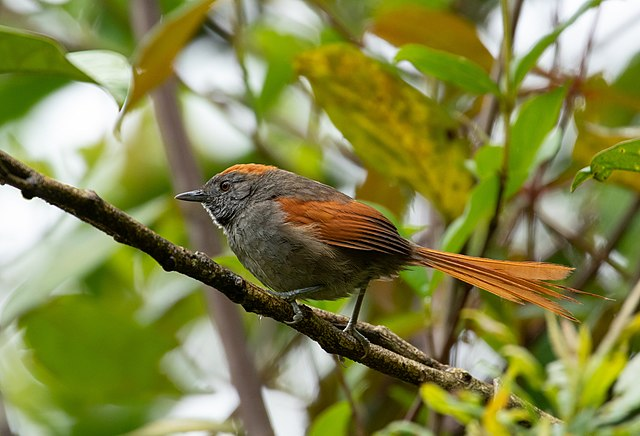

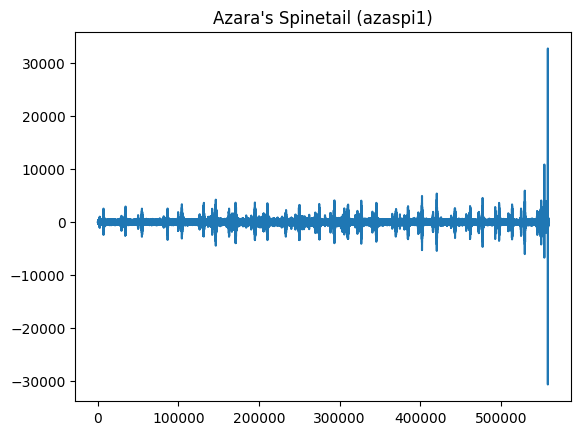

In [3]:
random_audio = get_random_audio_file()
show_bird_data(random_audio)

In [4]:
commands = np.array(tf.io.gfile.listdir(str('./dataset/small_birds_dataset/train')))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['azaspi1' 'chcant2' 'houspa' 'redcro' 'wbwwre1']


In [34]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='./dataset/small_birds_dataset/train',
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=400000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 241 files belonging to 5 classes.
Using 193 files for training.
Using 48 files for validation.

label names: ['azaspi1' 'chcant2' 'houspa' 'redcro' 'wbwwre1']


In [35]:
train_ds.element_spec

(TensorSpec(shape=(None, 400000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [36]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [37]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [38]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 400000)
(64,)


In [39]:
label_names[[1,2,3,0]]

array(['chcant2', 'houspa', 'redcro', 'azaspi1'], dtype='<U7')

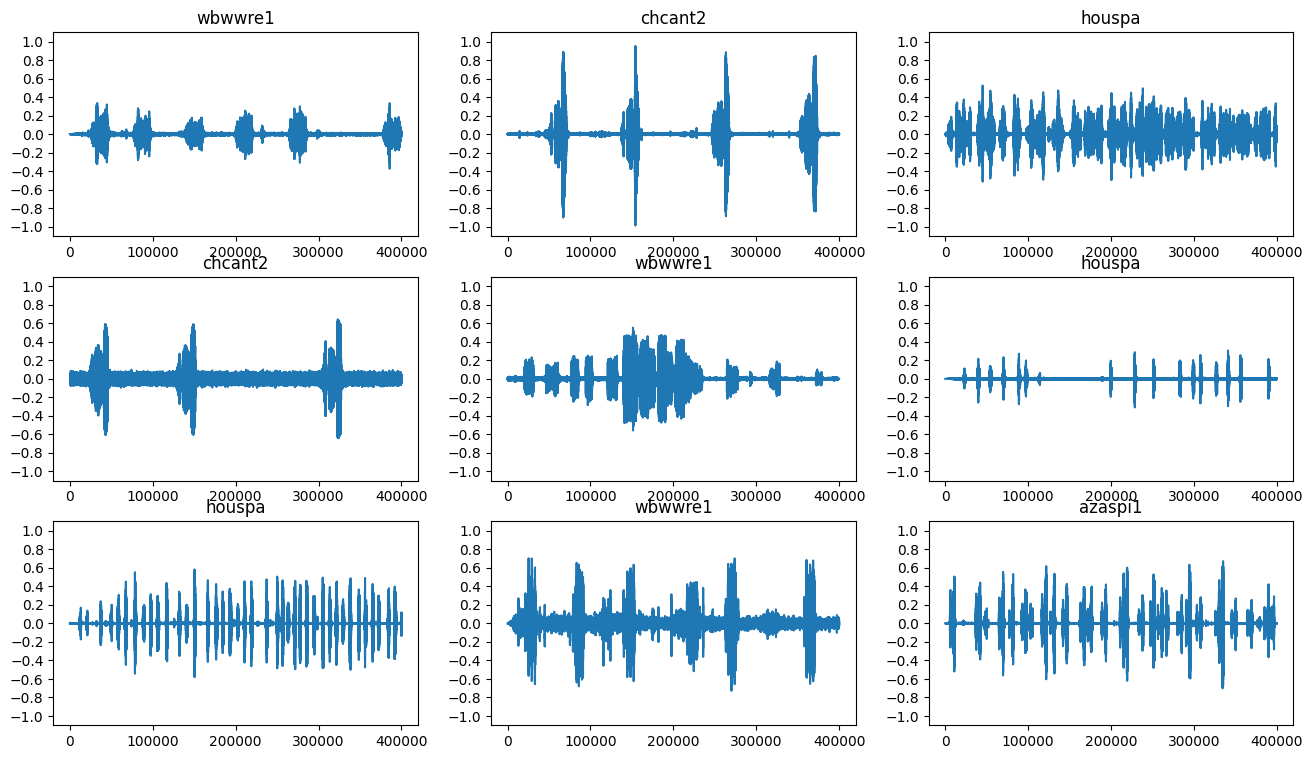

In [40]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [41]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [42]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

NameError: name 'waveform' is not defined

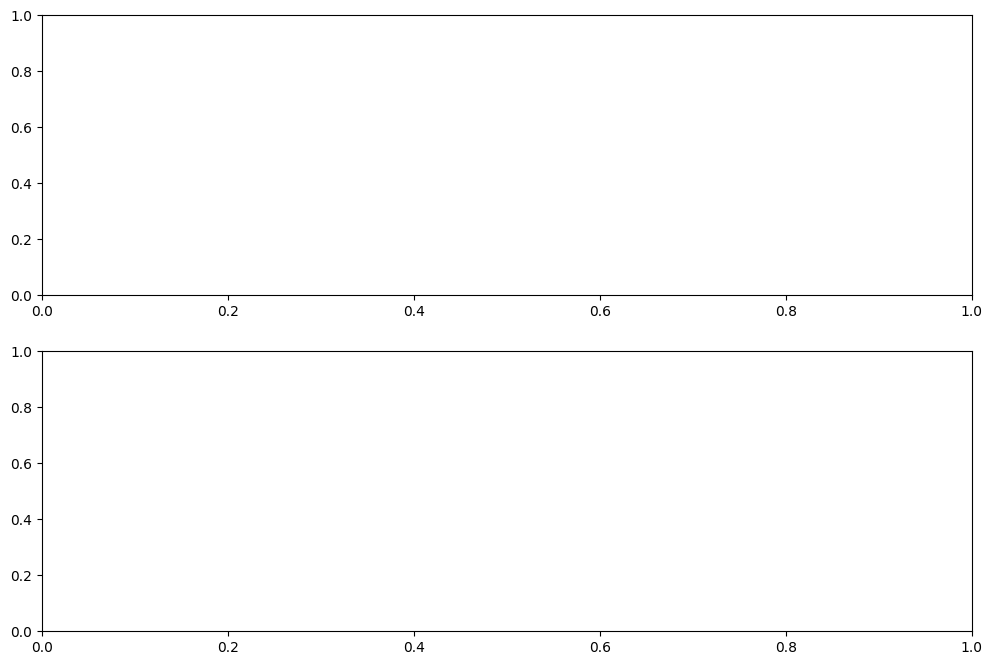

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [43]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [44]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [45]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

C:\Users\Dell\AppData\Local\Temp\ipykernel_4664\3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


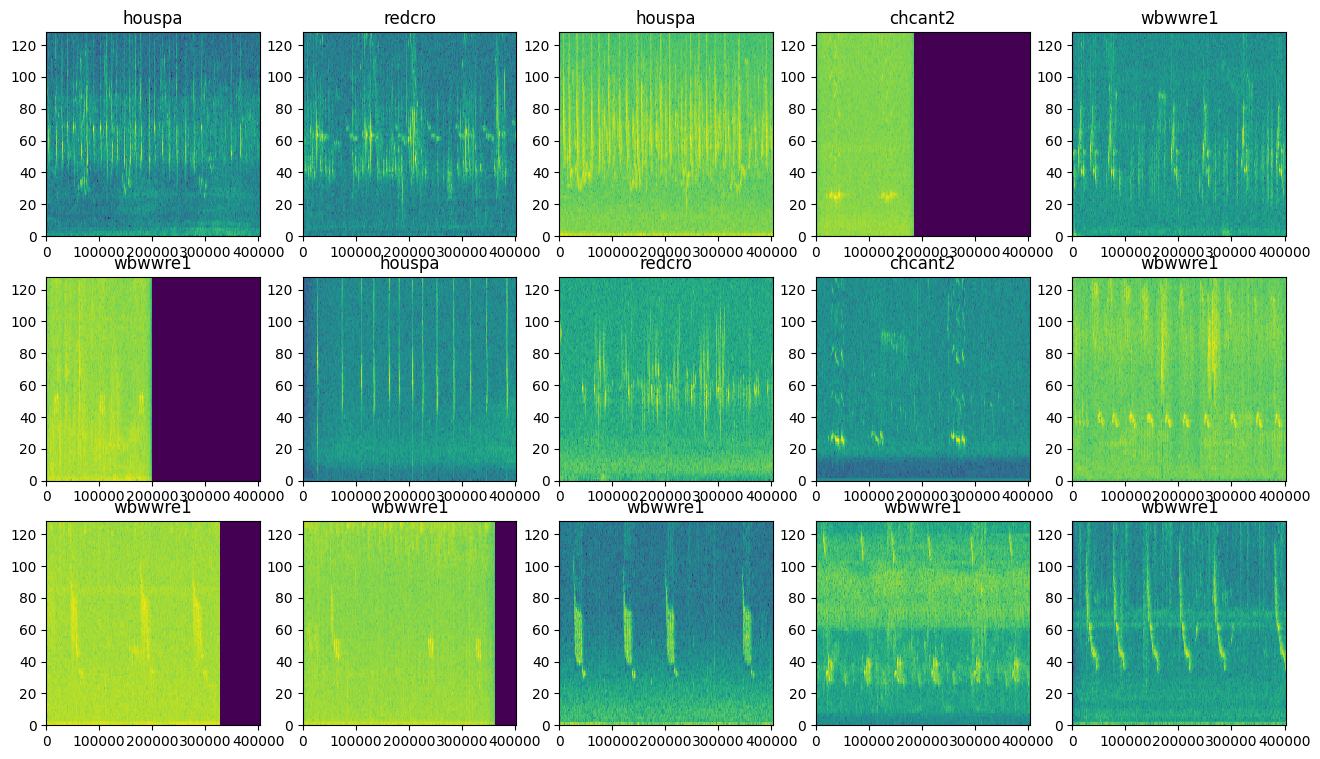

In [46]:
rows = 3
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

In [47]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [48]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (3124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)      

In [49]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [50]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
4/4 [==============================] - 1s 121ms/step - loss: 1.6112 - accuracy: 0.3057
Epoch 2/10
4/4 [==============================] - 0s 91ms/step - loss: 1.1665 - accuracy: 0.5078
Epoch 3/10
4/4 [==============================] - 0s 89ms/step - loss: 0.8999 - accuracy: 0.6425
Epoch 4/10
4/4 [==============================] - 0s 86ms/step - loss: 0.8374 - accuracy: 0.6891
Epoch 5/10
4/4 [==============================] - 0s 88ms/step - loss: 0.7414 - accuracy: 0.7150
Epoch 6/10
4/4 [==============================] - 0s 87ms/step - loss: 0.7129 - accuracy: 0.7150
Epoch 7/10
4/4 [==============================] - 0s 89ms/step - loss: 0.6820 - accuracy: 0.7306
Epoch 8/10
4/4 [==============================] - 0s 89ms/step - loss: 0.6400 - accuracy: 0.7617
Epoch 9/10
4/4 [==============================] - 0s 86ms/step - loss: 0.5158 - accuracy: 0.7927
Epoch 10/10
4/4 [==============================] - 0s 110ms/step - loss: 0.4625 - accuracy: 0.8083


Text(0, 0.5, 'Accuracy [%]')

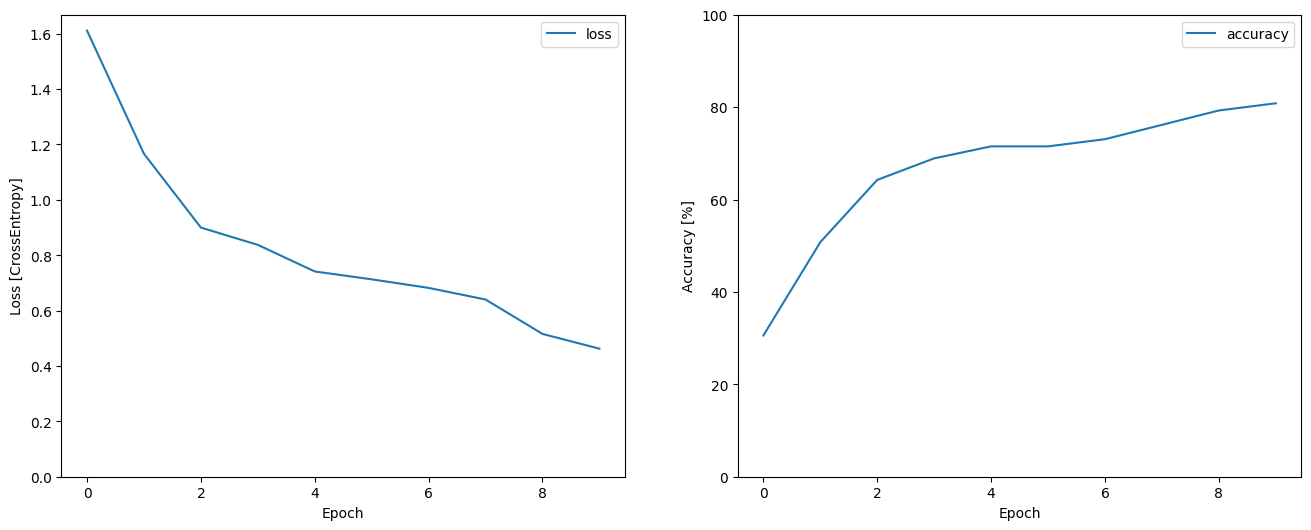

In [51]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [52]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 2s 2s/step - loss: 0.9545 - accuracy: 0.6667


{'loss': 0.9545193314552307, 'accuracy': 0.6666666865348816}

In [53]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 78ms/step


In [54]:
y_pred = tf.argmax(y_pred, axis=1)

In [55]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

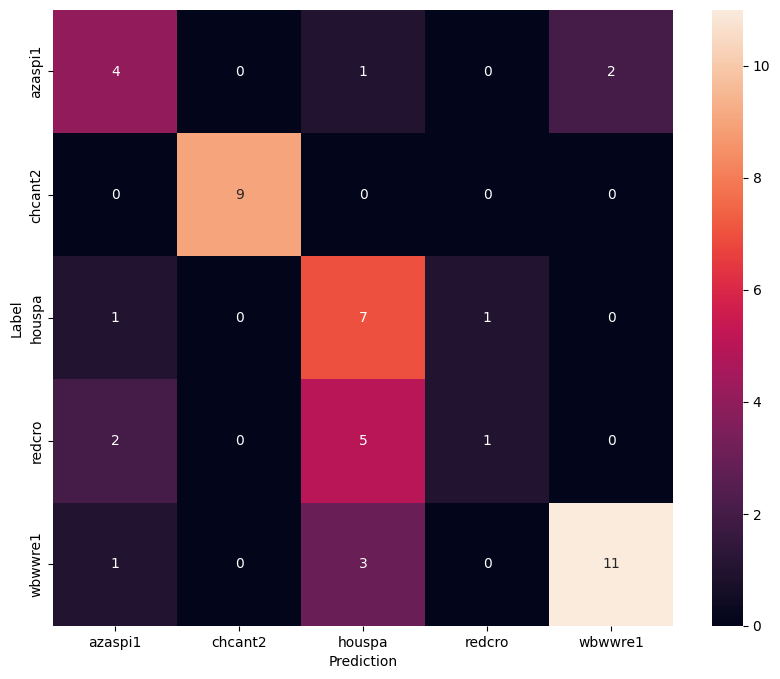

In [56]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()